In [1]:
from functools import partial
from math import sqrt
from pathlib import Path
import geopandas as gpd
from itertools import product

In [2]:
input_dir = Path('vector_1000')
output_dir = Path.cwd()

# Get a list of all GPKG files in the folder
v_files = list(sorted(input_dir.glob('*.gpkg')))

In [3]:
# Specify the number of files to open
num_files_to_open = 20

In [4]:
%%time
# Loop through each GPKG file and join
for i, file in enumerate(v_files[:num_files_to_open]):
    col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
    df = gpd.read_file(file)
    df.columns = [col_name, *df.columns[1:]] #Setting the column to the file
    if i == 0:
        combined_df = df.copy()
    else:
        combined_df = gpd.overlay(combined_df, df)

CPU times: total: 78.1 ms
Wall time: 3.34 s


In [5]:
def is_prime(n):
    count = 0
    if n > 1:
        for i in range(1, n + 1):
            if n % i == 0:
                count += 1
    return count == 2

def is_polygonal(s, x):
    assert s > 2 and s % 1 == 0 and x % 1 == 0
    n = (sqrt(8 * (s - 2) * x + (s - 4) ** 2) + (s - 4)) / (2 * (s - 2))
    return n % 1 == 0

def is_fibonacci(n):
    a, b = 0,1
    while a < n:
        a, b = b, a + b
    return a == n

def is_perfect(n):
    sum = 1
    i = 2
    while i * i <= n:
        if n % i == 0:
            sum = sum + i + n/i
        i += 1
    return sum == n and n != 1

In [6]:
%%time
combined_df['sum'] = combined_df.select_dtypes(include='number').sum(axis=1)
classes = [
    ('is_prime', is_prime),
    ('is_triangular', partial(is_polygonal, 3)),
    ('is_rectangular', partial(is_polygonal, 4)),
    ('is_pentagonal', partial(is_polygonal, 5)),
    ('is_hexagonal', partial(is_polygonal, 6)),
    ('is_fibonacci', is_fibonacci),
    ('is_perfect', is_perfect),
]
for i, func in enumerate(classes):
    combined_df[func[0]] = combined_df['sum'].apply(func[1])

CPU times: total: 0 ns
Wall time: 26.1 ms


In [7]:
numerics = list(combined_df.select_dtypes(include='number'))
combined_df = combined_df.drop(columns=numerics)

In [8]:
combinations = list(product([True, False], repeat=7))
class_mapping = {tuple(row): f'Class_{i+1:03}' for i, row in enumerate(combinations)}
combined_df['class'] = combined_df[['is_prime','is_triangular','is_rectangular','is_pentagonal','is_hexagonal','is_fibonacci','is_perfect']].apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1)
combined_df=combined_df[['class','geometry']]

In [9]:
output_dir.mkdir(parents=True, exist_ok=True)
output = (output_dir / 'v.gpkg')
# output.touch(exist_ok=True)
combined_df.to_file(output, layer='benchmarking', driver='GPKG', mode='w')

<Axes: >

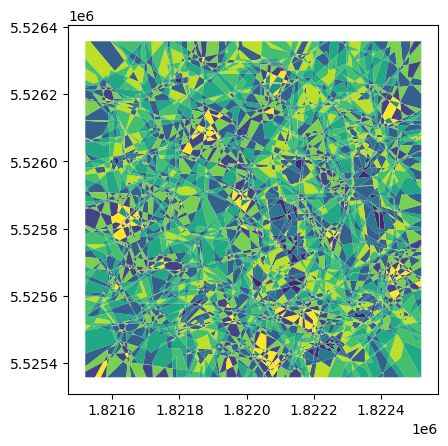

In [10]:
combined_df.plot('class', cmap='viridis')